## Training the model

This dataset contains the sign and symptpom data of newly diabetic or would be diabetic patient.

In [124]:
%%capture
%pip install pandas matplotlib pypdf python-dotenv google.generativeai scikit-learn

In [81]:
import os
import re
import json
import pandas as pd
from pypdf import PdfReader
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import google.generativeai as genai
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

load_dotenv()

True

In [82]:
df = pd.read_csv('diabetes_data.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


Before any modeling or preprocessing, it is critical to understand **what each column represents clinically**.  

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [84]:
mapping = {
    "Yes": 1,
    "No": 0,
    "Positive": 1,
    "Negative": 0,
    "Male": 1,
    "Female": 0
}

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].map(mapping)

df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


Age                   0.108679
Gender               -0.449233
Polyuria              0.665922
Polydipsia            0.648734
sudden weight loss    0.436568
weakness              0.243275
Polyphagia            0.342504
Genital thrush        0.110288
visual blurring       0.251300
Itching              -0.013384
Irritability          0.299467
delayed healing       0.046980
partial paresis       0.432288
muscle stiffness      0.122474
Alopecia             -0.267512
Obesity               0.072173
class                 1.000000
Name: class, dtype: float64


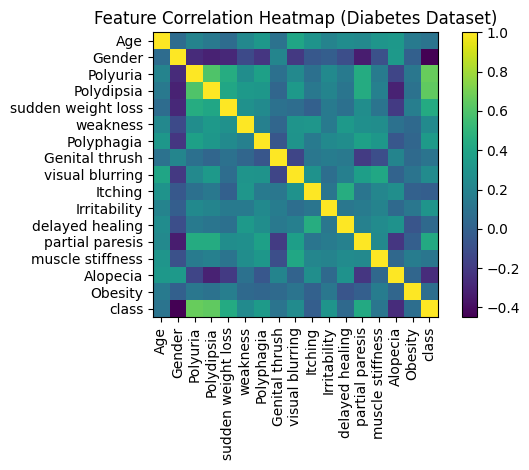

In [85]:
corr = df.corr()
print(corr.iloc[-1])
plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Heatmap (Diabetes Dataset)")
plt.tight_layout()
plt.show()

| Feature | Clinical Meaning | Relation to Diabetes | Signal Strength |
|-------|-----------------|---------------------|----------------|
| Age | Patient age | Risk increases with age | Low |
| Gender | Biological sex | Population-level risk modifier | Very Low |
| Polyuria | Frequent urination | Excess glucose excreted via urine | Very High |
| Polydipsia | Excessive thirst | Dehydration from polyuria | Very High |
| Sudden Weight Loss | Rapid unintended weight loss | Fat/muscle breakdown due to insulin dysfunction | High |
| Weakness | General fatigue | Reduced cellular energy uptake | Medium |
| Polyphagia | Excessive hunger | Cells unable to utilize glucose | Medium |
| Genital thrush | Fungal infection | High glucose promotes infection | Low |
| Visual Blurring | Vision changes | Lens distortion from high glucose | Medium |
| Itching | Skin irritation | Often linked to infection/dry skin | Low |
| Irritability | Mood changes | Blood glucose fluctuations | Medium |
| delayed healing | Slow wound recovery | Impaired circulation & immunity | Low |
| partial paresis | Nerve weakness | Diabetic neuropathy indicator | High |
| muscle stiffness | Muscular rigidity | Circulatory/neuropathic effect | Low |
| Alopecia | Hair loss | Metabolic/hormonal stress | Very Low |
| Obesity | Excess body fat | Major contributor to insulin resistance | Low |
| class | Diabetes diagnosis label | Target variable (not a feature) | — |


In [86]:
X = df.drop(columns="class")
y = df["class"]
X.shape, y.shape

((520, 16), (520,))

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((416, 16), (104, 16), (416,), (104,))

In [88]:
rf = RandomForestClassifier(
    n_estimators=100
)

rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
y_pred = rf.predict(X_test)
y_pred[:10]


array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [90]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9423076923076923

In [91]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[37,  3],
       [ 3, 61]])

## AGENT 1 — Ingestion Identifier Agent

The Ingestion Identifier Agent determines the data modality and format of the user-uploaded data and routes it to the appropriate downstream pipeline.

In [92]:
class IngestionIdentifierAgent:
    def identify(self, file_path: str):
        extension = os.path.splitext(file_path)[1].lower()

        if extension == ".csv":
            return {
                "modality": "tabular",
                "format": "csv"
            }
        elif extension in [".xls", ".xlsx"]:
            return {
                "modality": "tabular",
                "format": "excel"
            }
        elif extension in [".png", ".jpg", ".jpeg"]:
            return {
                "modality": "image",
                "format": "image"
            }
        elif extension == ".pdf":
            return {
                "modality": "text",
                "format": "pdf"
            }
        else:
            raise ValueError(f"Unsupported file type: {extension}")


In [125]:
file_path = "Patient Form.pdf"

reader = PdfReader(file_path)
agent = IngestionIdentifierAgent()
result = agent.identify(file_path)

print(f"File: {file_path}")
print(f"Result: {result}")


File: Patient Form.pdf
Result: {'modality': 'text', 'format': 'pdf'}


## AGENT 2 — Data Anonymization Agent 

The Data Anonymization Agent detects and masks personally identifiable information (PII) before downstream processing.

In [94]:
class DataAnonymizationAgent:
    def anonymize_text(self, text: str):
        pii_fields = []

        name_pattern = r"(?im)^\s*(patient\s*)?name\s*:\s*[A-Za-z\s]+"
        if re.search(name_pattern, text):
            pii_fields.append("NAME")
            text = re.sub(name_pattern, "Patient Name: [ANONYMIZED_NAME]", text)

        ssn_pattern = r"\b\d{3}-\d{2}-\d{4}\b|\b\d{9}\b"
        if re.search(ssn_pattern, text):
            pii_fields.append("SSN")
            text = re.sub(ssn_pattern, "[ANONYMIZED_SSN]", text)
            text = re.sub(r"\s+", " ", text)

        return {
            "text": text,
            "pii_detected": len(pii_fields) > 0,
            "pii_fields": pii_fields
        }


In [95]:
anonymizer = DataAnonymizationAgent()
anon_result = anonymizer.anonymize_text(reader.pages[0].extract_text())
anon_result

{'text': 'Patient Intake Form — Diabetes Risk Assessment Patient Name: [ANONYMIZED_NAME]: [ANONYMIZED_SSN] Age: 45 Gender: Male Over the past several weeks, the patient has noticed a clear change in their day-to-day health patterns. They report needing to urinate far more frequently than usual, including multiple times during the night, and this has been accompanied by a persistent sensation of thirst that does not seem to improve even with increased fluid intake. During the same period, the patient has experienced a noticeable and unintended loss of body weight, despite maintaining their normal diet and, in some instances, feeling hungrier than usual and consuming larger meals. In addition to these metabolic symptoms, the patient mentions occasional episodes of blurred vision, particularly later in the day, as well as increased irritability that they attribute to fluctuations in their overall well-being. However, they explicitly deny experiencing generalized weakness or fatigue that i

## AGENT 3 — Feature Extraction Agent

Following the paper’s modular agent-based design, the ingestion layer can route the same input
to multiple downstream pipelines depending on the use case.

In this prototype, I intentionally implement only one downstream path for PDF inputs:
PDF → Anonymization → Feature Extraction → Modeling.

In [96]:
api_key = os.environ.get("GEMINI_API_KEY")
genai.configure(api_key=api_key)

model_name = None
for model in genai.list_models():
    if 'generateContent' in model.supported_generation_methods:
        model_name = model.name.replace("models/", "")
        print(f"✓ Using model: {model_name}")
        break
model = genai.GenerativeModel(model_name)

✓ Using model: gemini-2.5-flash


In [97]:
class GeminiFeatureExtractionAgent:
    def extract(self, text):
        text = re.sub(r"\s+", " ", text).strip()
        prompt = f"""Extract structured medical features from the text below.

                        Rules:
                        - Return ONLY valid JSON.
                        - Do not explain anything.
                        - Use exactly these keys if present
                            - For Gender, use "Male" or "Female".
                            - For all other features, use "Yes", "No".
                            - For Age, use an integer for Age.
                        - Do not guess or diagnose.
                        - Dont omit any features. JSON should have all the keys. Just put "NaN" for unknown features.

                        Keys:
                        Age, Gender, Polyuria, Polydipsia, sudden weight loss,
                        weakness, Polyphagia, Genital thrush, visual blurring,
                        Itching, Irritability, delayed healing, partial paresis,
                        muscle stiffness, Alopecia, Obesity

                        Text:
                        {text}"""

        response = model.generate_content(
            prompt,
            generation_config={"temperature": 0}
        )
        return json.loads(response.text.replace("```json", "").replace("```", "").strip())

In [98]:
agent3 = GeminiFeatureExtractionAgent()
features = agent3.extract(anon_result["text"])
features

{'Age': 45,
 'Gender': 'Male',
 'Polyuria': 'Yes',
 'Polydipsia': 'Yes',
 'sudden weight loss': 'Yes',
 'weakness': 'No',
 'Polyphagia': 'Yes',
 'Genital thrush': 'No',
 'visual blurring': 'Yes',
 'Itching': 'No',
 'Irritability': 'Yes',
 'delayed healing': 'No',
 'partial paresis': 'No',
 'muscle stiffness': 'No',
 'Alopecia': 'No',
 'Obesity': 'No'}

## Agent 4 — Model–Data Matcher

Following the paper’s agent-based architecture, the Model–Data Matcher is responsible for
aligning test characteristics with an appropriate modeling.

Since I have only one model, instead of matching the test characteristics with a model, I am validating whether the chosen model is appropriate for this use case.

In [106]:
class ModelAppropriatenessAgent:
    def evaluate(self, features):
        prompt = f"""
                    You are an ML system design assistant.

                    A Random Forest classifier has been selected for a healthcare use case.

                    Extracted patient features (example input shape):
                    {features}

                    Dataset characteristics:
                    - Task: Binary classification (diabetes prediction)
                    - Data type: Tabular
                    - Size: ~500 samples
                    - Features: Mostly binary categorical features with one numeric feature (Age)
                    - Domain: Healthcare
                    - Goal: Reliable baseline model

                    Question:
                    Is Random Forest an appropriate model choice for this use case?

                    Rules:
                    - Return ONLY valid JSON.
                    - Do not include markdown or extra text.
                    - Do not suggest alternative models.
                    - Do not discuss training or tuning.

                    JSON schema:
                    {{
                    "model": "string",
                    "appropriate": boolean,
                    "reason": "string"
                    }}
                    """.strip()

        response = model.generate_content(
            prompt,
            generation_config={"temperature": 0}
        )

        return json.loads(response.text)


In [107]:
agent4 = ModelAppropriatenessAgent()
decision = agent4.evaluate(features)
decision

{'model': 'Random Forest',
 'appropriate': True,
 'reason': 'Random Forest is a robust ensemble model well-suited for tabular data with mixed feature types (numeric and categorical). It generally performs well on relatively small datasets (~500 samples) and is considered a strong, reliable choice for establishing a baseline in binary classification tasks, even in sensitive domains like healthcare.'}

## AGENT 5 — Inference Agent

Takes structured features and produces a prediction using the models

In [108]:
X_input = pd.DataFrame([{
    k: (
        1 if v == "Yes" else
        0 if v == "No" else
        1 if (k == "Gender" and v == "Male") else
        0 if (k == "Gender" and v == "Female") else
        v
    )
    for k, v in features.items()
}])

X_input = X_input[X.columns]
X_input

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,45,1,1,1,1,0,1,0,1,0,1,0,0,0,0,0


In [110]:
prediction = rf.predict(X_input)[0]
probability = rf.predict_proba(X_input)[0][1]
prediction, probability

(np.int64(1), np.float64(1.0))

In [118]:
class InferenceInterpretationAgent:
    def interpret(self, prediction, probability, features):

        prompt = f"""
            You are a clinical decision support assistant.

            A machine learning model has produced the following output for a patient:
            - Prediction: {prediction} (1 = high diabetes risk, 0 = low risk)
            - Risk score: {probability}

            Patient features (for context only):
            {features}

            Task:
            Provide a concise, human-readable interpretation of the model output.

            Rules:
            - Do NOT diagnose.
            - Do NOT contradict the model.
            - Do NOT introduce new clinical facts.
            - Do NOT provide treatment advice.
            - Use cautious, non-deterministic language.

            Return ONLY valid JSON in the following format:
            {{
            "risk_level": "Low | Moderate | High",
            "inference": "string",
            "disclaimer": "string"
            }}
            """.strip()

        response = model.generate_content(
            prompt,
            generation_config={"temperature": 0}
        )
        return json.loads(response.text.replace("```json", "").replace("```", "").strip())


In [119]:
agent5 = InferenceInterpretationAgent()

interpretation = agent5.interpret(
    prediction=prediction,
    probability=probability,
    features=features
)

interpretation

{'risk_level': 'High',
 'inference': "The machine learning model predicts a high likelihood of diabetes risk for this patient, with a risk score of 1.0. This assessment is based on the patient's input features, including reported symptoms such as polyuria, polydipsia, sudden weight loss, polyphagia, visual blurring, and irritability.",
 'disclaimer': 'This output is from an AI model and is for informational purposes only. It does not constitute a medical diagnosis or treatment recommendation. Clinical decisions should always be made by a qualified healthcare professional.'}